In [1]:
import os, os.path
import numpy as np
from time import time
import pandas as pd
import math as m
import setup_runs as sr
import importlib
import matplotlib.pyplot as plt
import itertools

In [284]:
df_params = pd.read_csv(sr.fp_csv_parameter_ranges)
dir_car = os.path.join(sr.dir_ref, "carlos_params")
all_files_car = os.listdir(dir_car)
dict_car = {}
dict_compare = {}

fields_merge = ["sector", "time_series_id", "strategy_id", "type", "parameter"]
df_init_q = True

for fn in all_files_car:
    k = fn.replace("parameter_ranges_", "").replace(".csv", "")
    df_tmp = pd.read_csv(os.path.join(dir_car, fn))
    dict_car.update({k: df_tmp})
    
    if df_init_q:
        fields_ord_check = [x for x in df_tmp.columns if (x not in fields_merge) and (x not in ["normalize_group", "parameter_constant_q"])]
        dict_rnm = dict([[x, x + "_" + k] for x in fields_ord_check])
        df_tmp = df_tmp.rename(columns = dict_rnm)
        df_full = df_tmp
        df_init_q = False
    else:
        dict_rnm = dict([[x, x + "_" + k] for x in fields_ord_check])
        df_tmp = df_tmp.rename(columns = dict_rnm)
        df_full = pd.merge(df_full, df_tmp, how = "left", on = fields_merge)
    fields_ord_add = [dict_rnm[x] for x in fields_ord_check]
    
    dict_compare.update({k: fields_ord_add})

#parameters that vary across them
check_params = set({})
#parameters that are nearly identical
set_close_traj = set({})
#do checks
for i in range(len(df_full)):
    k0 = list(dict_compare.keys())[0]
    vec = np.array(df_full[dict_compare[k0]].iloc[i])
    param = df_full["parameter"].iloc[i]
    ts = df_full["time_series_id"].iloc[i]
    s = df_full["strategy_id"].iloc[i]
    
    proceed_q = True
    for fn in dict_compare.keys():
        vec_fn = np.array(df_full[dict_compare[fn]].iloc[i])
        checkr_q = (False not in (vec_fn == vec))
        
        if (not checkr_q) and (vec_fn[0] == vec[0]) and (vec_fn[-1] == vec[-1]):
            set_close_traj = set_close_traj | set({param})
        if False:
            if not checkr_q:
                print("For param '" + param + "' and (ts, strat) = (" + str(ts) + ", " + str(s) + "):\t\t" + k0 + " != " + fn)
                if k0 == fn:
                    print("vals:")
                    print(vec)
                    print(np.array(df_full[dict_compare[fn]].iloc[i]))
                    print(vec == np.array(df_full[dict_compare[fn]].iloc[i]))
                    print("\n")
        proceed_q = proceed_q & checkr_q
        
    if not proceed_q:
        check_params = check_params | set({param})

#some strings to repl        
replcers = ["diesel", "solar", "electricity", "electricitiy", "electric", "natural_gas", "pliqgas", "hyb", "hydrogen", "coal", "fuel_oil", "gasoline"]

def do_rep(str_in):
    s = str_in
    for r in replcers:
        r2 = "_" + r
        s = s.replace(r2, "")
    return s

set_params_grouping = set([do_rep(x) for x in list(check_params)])
set_traj = set([x for x in check_params if "residential_emission_fact" in x])
set_grad = check_params - set_traj
set_params_grouping = set_params_grouping - set({"residential_emission_fact"})



In [325]:
transport_frac_private in 

{'copper_heat',
 'copper_open_pit_mine',
 'other_industries_heat',
 'residential_apartment_acs',
 'residential_house_acs',
 'transport_frac_private',
 'transport_frac_truck'}

In [285]:
dict_traj_repl = {"pessimistic": "traj_a", "optimistic": "traj_b"}
yrs = [str(x) for x in range(2015, 2051)]
dict_array_k = {}
dict_array_a = {}
dict_array_b = {}
dict_array_def = {}
dict_params_out = {}
#initialize dictionary to match parameter to its LHS trial group
spg = list(set_params_grouping)
spg.sort()
dict_spg = dict([[spg[i], i + 1] for i in range(len(spg))])

tg_str = "trajgroup"

for p in set_grad:#{"residential_apartment_acs_electric"}:
    

    dict_tmp = {}
    #extract data from each dataframe
    for k in dict_car.keys():
        array_tmp = dict_car[k][dict_car[k]["parameter"] == p].copy().sort_values(by = ["time_series_id", "strategy_id"])
        df_tmp = array_tmp[[x for x in array_tmp.columns if x not in yrs]].reset_index(drop = True)
        array_tmp = np.array(array_tmp[yrs])
        
        if k in dict_traj_repl.keys():
            key_new = dict_traj_repl[k]
        else:
            key_new = k
        dict_tmp.update({key_new: array_tmp})
        
    #build new parameters
    array_a = dict_tmp["traj_a"]
    array_b = dict_tmp["traj_b"]
    array_def = dict_tmp["ndc"]
    
    #get array of values 
    array_k = []
    
    for r in range(len(array_def)):
        v_a = array_a[r]
        v_b = array_b[r]
        v_d = array_def[r]
        n = len(v_d) - 1
         
        if v_d[n] == v_a[n]:
            v_d = v_d*1.0001
        v_k = np.array((v_d - v_a)/(v_b - v_a))
        w = np.where(v_k == np.inf)
        v_k[w] = 0
        array_k.append(v_k)    
    #convert
    array_k = np.nan_to_num(np.array(array_k))
    #get ranges
    range_mix_min = np.zeros(len(array_k))
    range_mix_max = 1/np.array(array_k[:,-1])
    range_mix_max = np.nan_to_num(range_mix_max)
    #check crrent param
    for spg in set_params_grouping:
        if spg in p:
            add_key = p.replace((spg + "_"), "")
            
            traj_str_spg = tg_str + "_" + str(dict_spg[spg])
            traj_str = traj_str_spg + "-lhs"
            
            if spg in dict_array_k.keys():
                dict_array_k[spg].update({add_key: array_k})
                dict_array_a[spg].update({add_key: array_a})
                dict_array_b[spg].update({add_key: array_b})
                dict_array_def[spg].update({add_key: array_def}) 
            else:
                dict_array_k[spg] = {add_key: array_k}
                dict_array_a[spg] = {add_key: array_a}
                dict_array_b[spg] = {add_key: array_b}
                dict_array_def[spg] = {add_key: array_def}
                
                #initialize parameter ranging variable (will only create once)
                array_pvar = np.ones(array_k.shape)
                df_array_pvar = df_tmp.copy()
                df_array_pvar["parameter"] = df_array_pvar["parameter"].replace({p: traj_str})
                df_array_pvar = pd.concat([df_array_pvar, pd.DataFrame(array_pvar, columns = yrs)], axis = 1)
                #update the constant q
                df_array_pvar["parameter_constant_q"] = [1 for i in range(len(df_array_pvar))]
                df_array_pvar["min_2050"] = np.zeros(len(df_array_pvar))
                df_array_pvar["max_2050"] = np.ones(len(df_array_pvar))
                dict_params_out.update({traj_str: df_array_pvar})
    ##  build parameter out
    
    #max trajectory
    traj_str_max = traj_str_spg + "-trajmax_" + p
    df_p_max = pd.concat([df_tmp, pd.DataFrame(array_b, columns = yrs)], axis = 1)
    df_p_max["min_2050"] = np.ones(len(df_p_max))
    df_p_max["max_2050"] = np.ones(len(df_p_max))
    df_p_max["parameter"] = [traj_str_max for i in range(len(df_p_max))]
    #min trajectory
    traj_str_min = traj_str_spg + "-trajmin_" + p
    df_p_min = pd.concat([df_tmp, pd.DataFrame(array_a, columns = yrs)], axis = 1)
    df_p_min["min_2050"] = np.ones(len(df_p_min))
    df_p_min["max_2050"] = np.ones(len(df_p_min))
    df_p_min["parameter"] = [traj_str_min for i in range(len(df_p_min))]
    #mix trajectory
    traj_str_mix = traj_str_spg + "-trajmix_" + p
    df_p_mix = pd.concat([df_tmp, pd.DataFrame(array_k, columns = yrs)], axis = 1)
    df_p_mix["min_2050"] = np.ones(len(df_p_mix))#range_mix_min
    df_p_mix["max_2050"] = np.ones(len(df_p_mix))#range_mix_max
    df_p_mix["parameter_constant_q"] = np.ones(len(df_p_mix))
    df_p_mix["parameter"] = [traj_str_mix for i in range(len(df_p_mix))]
    
    
    if p in set_close_traj:
        df_p_out = dict_car["ndc"][dict_car["ndc"]["parameter"] == p].copy().sort_values(by = ["time_series_id", "strategy_id"])
        print(p)
    else:
        #concat
        df_p_out = pd.concat([df_p_max, df_p_min, df_p_mix], axis = 0).reset_index(drop = True)
    
    #add parameter variable out
    dict_params_out.update({p: df_p_out})
                
                
        

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


other_industries_heat_hydrogen


In [328]:
#dict_params_out["transport_frac_private_gasoline"]

In [332]:
df_out = [dict_params_out[x] for x in dict_params_out.keys()]
df_out = pd.concat(df_out, axis = 0)
#parameters to exclude
set_trajgroups_excl = set([x for x in df_params["parameter"] if "trajgroup" in x])
#get parameters
df_params = pd.read_csv(sr.fp_csv_parameter_ranges)
df_params = df_params[~df_params["parameter"].isin(set(df_out["parameter"]) | set_grad)]
df_params = df_params[~df_params["parameter"].isin(set_trajgroups_excl)]
#join
df_export = pd.concat([df_params, df_out], axis = 0).sort_values(by = ["sector", "type", "parameter", "time_series_id", "strategy_id"]).reset_index(drop = True)
#df_export.to_csv(sr.fp_csv_parameter_ranges, index = None, encoding = "UTF-8")
#set([x for x in df_export["parameter"] if "trajgroup" in x])



In [336]:
df_export.shape

(3004, 45)

In [319]:
#df_export = df_export[~(df_export["parameter"].isin(set([x for x in df_export["parameter"] if "trajgroup_8" in x])))]
#[x for x in df_export["parameter"] if "trajgroup_7" in x]
#df_export.to_csv(sr.fp_csv_parameter_ranges, index = None, encoding = "UTF-8")
#df_export.shape
#set([x for x in df_export["parameter"] if "trajgroup_1" in x])
#len(set(df_export["parameter"]))
df_export.shape


(3016, 45)

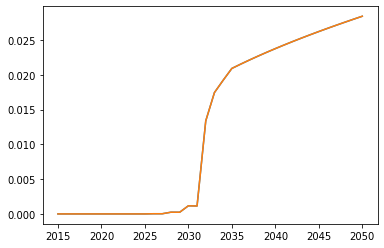

In [231]:
import matplotlib.pyplot as plt
y1 = dict_array_a["other_industries_heat"]["hydrogen"][0]
y2 = dict_array_b["other_industries_heat"]["hydrogen"][0]
x = list(range(2015, 2051))
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [236]:
y1-y2

array([ 0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00, -1.94e-08,
        3.31e-08,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00])